# 타이타닉 생존자 데이터 셋

In [46]:
# -q (quiet) 옵션은 설치 로그를 안보여줌(조용히함)
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
# 타이타닉 데이터셋 불러오기
# (pandas에 기본 내장된 예제 데이터셋)
import seaborn as sns
import pandas as pd

# titanic 데이터 DataFrame
titanic = sns.load_dataset('titanic')

# 처음 5개 행 보기
print("타이타닉 데이터 미리보기:")
print(titanic.head())

# 데이터셋 정보 확인
print("\n데이터셋 정보:")
print(titanic.info())

# 데이터 요약 통계
print("\n데이터 요약 통계:")
print(titanic.describe())

타이타닉 데이터 미리보기:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0 

## 사전 탐색

In [48]:
# col별 결측치 합계
titanic.isna().sum()

# 승객 등급 등장 빈도 (1, 2, 3 등석)
print(titanic['class'].value_counts())

# 성별 빈도 (남/녀)
print(titanic['sex'].value_counts())

# 생존 여부 빈도 (생존자/사망자)
print(titanic['survived'].value_counts())

class
Third     491
First     216
Second    184
Name: count, dtype: int64
sex
male      577
female    314
Name: count, dtype: int64
survived
0    549
1    342
Name: count, dtype: int64


In [49]:
# 성별에 따른 생존율
print(titanic.groupby('sex')['survived'].mean()*100)
# 위와 같은 방법인데, 더 복잡한 통계 가능
titanic.groupby('sex').agg({'survived': ['mean']})

# 승객 등급에 따른 생존율
print(titanic.groupby('class')['survived'].mean()*100)


sex
female    74.203822
male      18.890815
Name: survived, dtype: float64
class
First     62.962963
Second    47.282609
Third     24.236253
Name: survived, dtype: float64


C:\Users\agnes\AppData\Local\Temp\ipykernel_17216\360086901.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(titanic.groupby('class')['survived'].mean()*100)


In [50]:
# 성별 & 승객 등급에 따른 생존율
# unstack() 쓰면 두번째 index가 col이 됨
titanic.groupby(['sex', 'class'])['survived'].mean().unstack()

# 피벗테이블
titanic.pivot_table(
    values='survived',
    index='sex',
    columns='class',
    aggfunc='mean'
)


# 나이 그룹별 생존율
titanic['age_group'] = pd.cut(
    titanic['age'],
    bins=[0, 12, 18, 35, 60, 100], # 초과 ~ 이하
    labels=['아동', '청소년', '청년', '중장년', '노년'] # 어떻게 나누는게 더 의미있는 인사이트를 도출할까? 이건 분석가의 역량!!
)

titanic.head(3)

# 카테고리가 있는데, 해당되는 내용이 없을 때 표시할래? 말래? observed=True (있는것만 보여줘)
titanic.groupby('age_group')['survived'].mean()


# 성별 + 나이그룹으로 생존율 확인
titanic.groupby(['sex', 'age_group'])['survived'].mean().unstack()

C:\Users\agnes\AppData\Local\Temp\ipykernel_17216\3525409935.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])['survived'].mean().unstack()
C:\Users\agnes\AppData\Local\Temp\ipykernel_17216\3525409935.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table(
C:\Users\agnes\AppData\Local\Temp\ipykernel_17216\3525409935.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby('age_group')

age_group,아동,청소년,청년,중장년,노년
sex,,,,,
female,0.593750,0.750000,0.783333,0.771429,1.000000
male,0.567568,0.088235,0.180672,0.192000,0.105263


# 결측치 처리

In [51]:
# 결측치 확인
missing = titanic.isna().sum()

# 결측치 있는 항목만 확인
missing[missing>0]

# 결측 비율
missing_p = titanic.isna().mean() * 100
missing_p[missing_p>0]

age            19.865320
embarked        0.224467
deck           77.216611
embark_town     0.224467
age_group      19.865320
dtype: float64

In [52]:
# 결측치 채우기
# age: 중요한 정보: 평균/중앙값 대체
# embarked: 가장 많은 사람들이 탄 곳으로 대체
# deck: 추측 불가능(의미 없음) -> 삭제
titanic = sns.load_dataset('titanic')

# 보통 카피 떠서 진행! 기존 DF는 조회만, 새로 만든건 변경만!
titanic_processed = titanic.copy()

# 비어있던 행들 마스킹
age_mask = titanic['age'].isna()


# 나이 결측치 채우기 (남녀 상관없이 전체 평균으로 채운 것)
mean_age = titanic['age'].mean()
titanic_processed['age'] = titanic['age'].fillna(mean_age)

# 결측치 있는지 재확인
titanic_processed.isna().sum()

# 평균으로 채워진 값들만 확인
titanic_processed[age_mask]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
5,0,3,male,29.699118,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
17,1,2,male,29.699118,0,0,13.0000,S,Second,man,True,NaN,Southampton,yes,True
19,1,3,female,29.699118,0,0,7.2250,C,Third,woman,False,NaN,Cherbourg,yes,True
26,0,3,male,29.699118,0,0,7.2250,C,Third,man,True,NaN,Cherbourg,no,True
28,1,3,female,29.699118,0,0,7.8792,Q,Third,woman,False,NaN,Queenstown,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,male,29.699118,0,0,7.2292,C,Third,man,True,NaN,Cherbourg,no,True
863,0,3,female,29.699118,8,2,69.5500,S,Third,woman,False,NaN,Southampton,no,False
868,0,3,male,29.699118,0,0,9.5000,S,Third,man,True,NaN,Southampton,no,True
878,0,3,male,29.699118,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True


In [53]:
# 전체 평균으로 대체하는 게 옳을까...?
# 성별/객실별로 평균 나이를 추정하는건?


# 모든 사람들을 성별/객실 그룹의 평균 나이로 바꾼 Series -> .transform()은 value를 바꿔주는 거
mean_ages = titanic.groupby(['sex','pclass'])['age'].transform('mean')
print(mean_ages)

# titanic의 age col 중, 빈 값만 mean_ages로 채움
titanic_processed['age'] = titanic['age'].fillna(mean_ages)

# 원래 비어있던 애들만 확인
titanic_processed.loc[age_mask]

0      26.507589
1      34.611765
2      21.750000
3      34.611765
4      26.507589
         ...    
886    30.740707
887    34.611765
888    21.750000
889    41.281386
890    26.507589
Name: age, Length: 891, dtype: float64


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
5,0,3,male,26.507589,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
17,1,2,male,30.740707,0,0,13.0000,S,Second,man,True,NaN,Southampton,yes,True
19,1,3,female,21.750000,0,0,7.2250,C,Third,woman,False,NaN,Cherbourg,yes,True
26,0,3,male,26.507589,0,0,7.2250,C,Third,man,True,NaN,Cherbourg,no,True
28,1,3,female,21.750000,0,0,7.8792,Q,Third,woman,False,NaN,Queenstown,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,male,26.507589,0,0,7.2292,C,Third,man,True,NaN,Cherbourg,no,True
863,0,3,female,21.750000,8,2,69.5500,S,Third,woman,False,NaN,Southampton,no,False
868,0,3,male,26.507589,0,0,9.5000,S,Third,man,True,NaN,Southampton,no,True
878,0,3,male,26.507589,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True


In [54]:
# embarked (탑승 도시) -> 최빈값으로 채우겠다 

# 비어있는 항구 개수
titanic['embarked'].isna().sum()

# 최빈값 (Series - 벡터)
mode_embarked = titanic['embarked'].mode()[0] # Series에서 1개 뽑기

titanic_processed['embarked'] = titanic['embarked'].fillna(mode_embarked) # 시리즈를 타이타닉_프로세스에 넣어

#처리 완료 확인 (빈값 0)
titanic_processed['embarked'].isna().sum()

np.int64(0)

In [55]:
# deck은 77%가 비어있으니 삭제
titanic['deck'].isna().mean() *100 # 빈값 비율

# deck 컬럼 삭제 - inplace는 실행하면, 2번째 실행 불가능
titanic_processed.drop('deck', axis=1, inplace=True)


In [56]:
titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  889 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


# 타이타닉 이상치 처리

In [57]:
# 타이타닉 데이터셋 불러오기
# (seaborn 기본 내장된 예제 데이터셋)
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# titanic 데이터 DataFrame
titanic = sns.load_dataset('titanic')

# 수치 데이터에만 집중
numeric_cols = ['age', 'fare']
print("타이타닉 데이터셋 기본 정보:")
print(titanic[numeric_cols].describe())

타이타닉 데이터셋 기본 정보:
              age        fare
count  714.000000  891.000000
mean    29.699118   32.204208
std     14.526497   49.693429
min      0.420000    0.000000
25%     20.125000    7.910400
50%     28.000000   14.454200
75%     38.000000   31.000000
max     80.000000  512.329200


In [58]:
# 결측치(Missing Value) 처리 (이전에 배운 내용 활용)
titanic.isna().sum()

# 성별/객실 그룹의 평균 나이로 결측치 채우기
titanic_copy = titanic.copy()
mean_age = titanic.groupby(['sex', 'pclass'])['age'].transform('mean')

# 비어있는 값만 내가 설정해둔 평균으로 교체햇
titanic_copy['age'] = titanic['age'].fillna(mean_age)
titanic_copy.isna().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

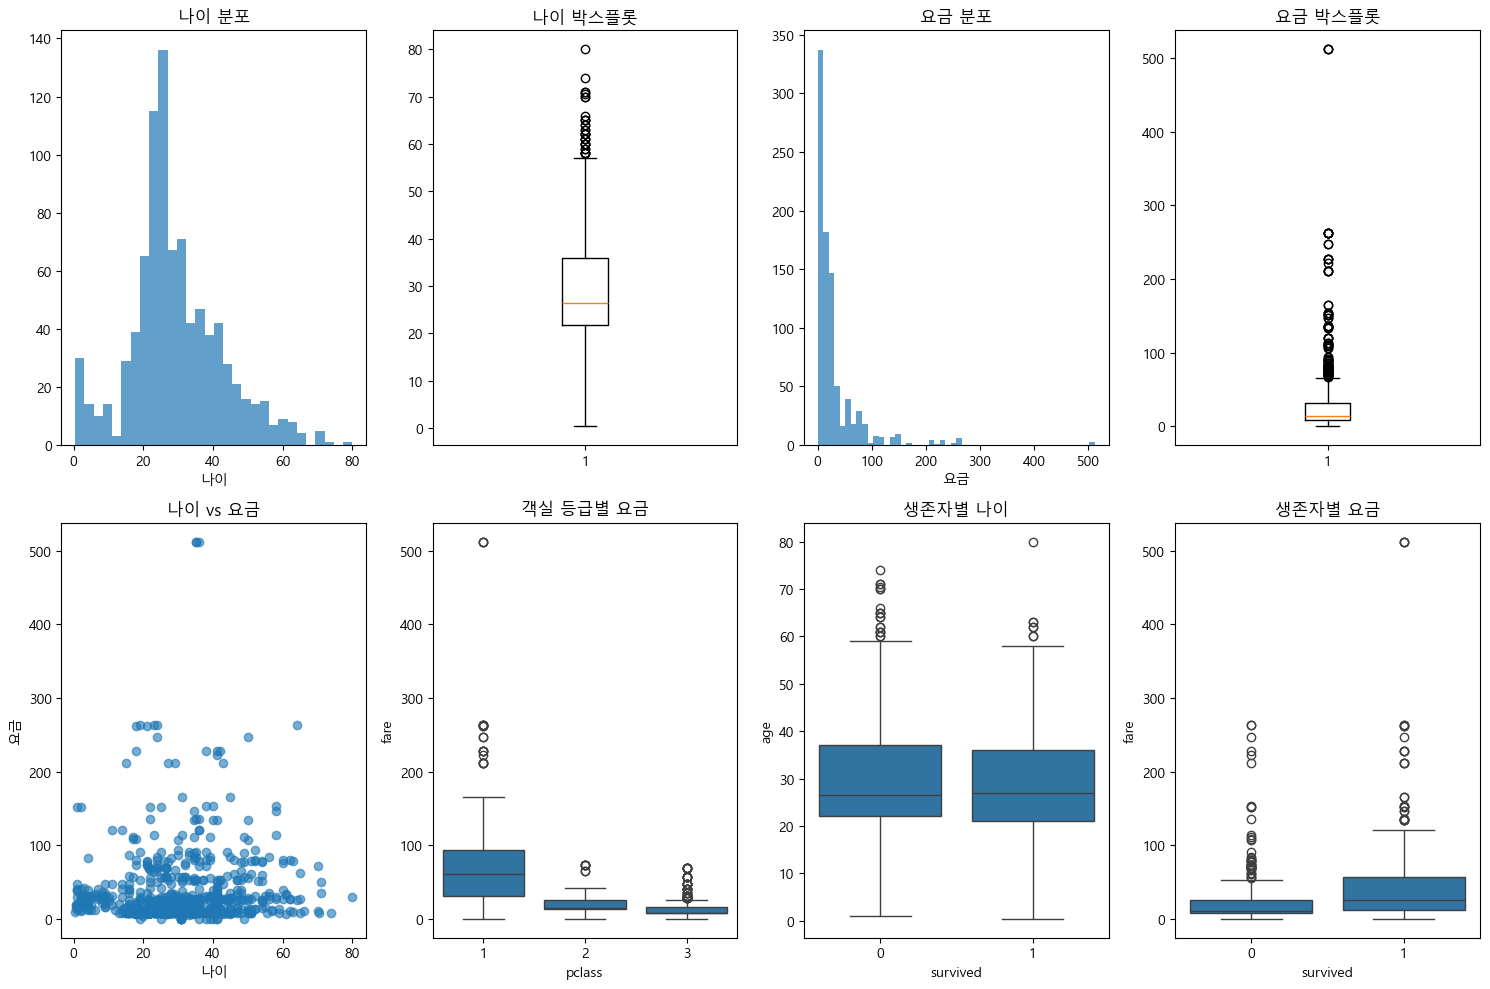

In [59]:
# 결측치 처리 안하면 제대로 시각화 제대로 안나옴

# 1. 이상치 탐지 및 시각화
plt.figure(figsize=(15, 10))

# 나이 분포
plt.subplot(2, 4, 1)
plt.hist(titanic_copy['age'], bins=30, alpha=0.7)
plt.title('나이 분포')
plt.xlabel('나이')

plt.subplot(2, 4, 2)
plt.boxplot(titanic_copy['age'])
plt.title('나이 박스플롯')

# 요금 분포
plt.subplot(2, 4, 3)
plt.hist(titanic_copy['fare'], bins=50, alpha=0.7)
plt.title('요금 분포')
plt.xlabel('요금')

plt.subplot(2, 4, 4)
plt.boxplot(titanic_copy['fare'])
plt.title('요금 박스플롯')

# 산점도
plt.subplot(2, 4, 5)
plt.scatter(titanic_copy['age'], titanic_copy['fare'], alpha=0.6)
plt.xlabel('나이')
plt.ylabel('요금')
plt.title('나이 vs 요금')

# 객실 등급별 요금 분포
plt.subplot(2, 4, 6)
sns.boxplot(x='pclass', y='fare', data=titanic_copy)
plt.title('객실 등급별 요금')

# 생존자별 나이 분포
plt.subplot(2, 4, 7)
sns.boxplot(x='survived', y='age', data=titanic_copy)
plt.title('생존자별 나이')

# 생존자별 요금 분포
plt.subplot(2, 4, 8)
sns.boxplot(x='survived', y='fare', data=titanic_copy)
plt.title('생존자별 요금')

plt.tight_layout()
plt.show()


In [60]:
titanic_copy[numeric_cols].describe()

,age,fare
count,891.000000,891.000000
mean,29.318643,32.204208
std,13.281103,49.693429
min,0.420000,0.000000
25%,21.750000,7.910400
50%,26.507589,14.454200
75%,36.000000,31.000000
max,80.000000,512.329200


In [61]:
# 2. 요금 데이터의 이상치 분석
# IQR 방법으로 이상치 탐지

def detect_outlier_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5*IQR)
    upper_bound = Q3 + (1.5*IQR)

    return (data_series < lower_bound) | (data_series > upper_bound)

# 이상치 개수
detect_outlier_iqr(titanic['fare']).sum()

outlier_person = detect_outlier_iqr(titanic['fare'])
outlier_passenger = titanic[outlier_person]

In [62]:
# 이상치에 해당하는 승객들 특성 분석
print(outlier_passenger.describe())


print(outlier_passenger.groupby('pclass')['survived'].sum())
print(outlier_passenger.groupby('sex')['survived'].sum())
print(outlier_passenger.groupby('age_group')['survived'].sum())

print("이상치 생존률", outlier_passenger['survived'].mean())
print("정상 생존률", outlier_passenger['survived'].mean())


         survived      pclass         age       sibsp       parch        fare
count  116.000000  116.000000  101.000000  116.000000  116.000000  116.000000
mean     0.681034    1.163793   34.266535    1.094828    0.655172  128.291629
std      0.468098    0.509799   14.717035    1.892679    0.885668   84.636908
min      0.000000    1.000000    0.920000    0.000000    0.000000   66.600000
25%      0.000000    1.000000   23.000000    0.000000    0.000000   78.189600
50%      1.000000    1.000000   35.000000    1.000000    0.000000   90.000000
75%      1.000000    1.000000   45.000000    1.000000    1.000000  147.778100
max      1.000000    3.000000   70.000000    8.000000    4.000000  512.329200
pclass
1    79
2     0
3     0
Name: survived, dtype: int64
sex
female    65
male      14
Name: survived, dtype: int64


KeyError: 'age_group'

In [ ]:
# 3. 객실 등급을 고려한 이상치 분석
# 객실 등급별로 요금 이상치 탐지

outlier_mask = titanic.groupby('pclass')['fare'].transform(detect_outlier_iqr)
outlier_mask.sum()

np.int64(89)

In [ ]:

def detect_outliers_by_group(data: pd.DataFrame, group_col: str, value_col: str):

    """그룹별 이상치 탐지"""
    # 우선 전원 모두 이상치 아닌 걸로 세팅 (False)
    outliers = pd.Series(False, data.index)

    # 현재 group_col에서 유니크한 범주를 뽑아내기 (pclass -> 1, 2, 3)
    for group in data[group_col].unique():

        # df[df['pclass'] == 3]['fare'] /  df[df['pclass'] == 1]['fare'] / 
        group_data = data[data[group_col] == group][value_col]

        Q1 = group_data.quantile(0.25)        
        Q3 = group_data.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        group_outliers = (group_data < lower) | (group_data > upper)
        
        outliers[group_data.index] = group_outliers

    return outliers
        
# 객실 등급별 이상한 사람들 (T/F mask series)
fare_outliers_by_pclass = detect_outliers_by_group(titanic_copy, 'pclass', 'fare')


In [ ]:
# 4. 이상치 처리 방법 적용 및 비교
# 방법 1: 제거
titanic_copy = titanic[~outlier_mask]
print(len(titanic))
print(len(titanic_copy))

titanic.drop(titanic[outlier_mask].index)

891
802


In [ ]:
# 방법 2: 윈저화 (95% 백분위수로 제한)

titanic_winsorized = titanic.copy()
upper_limit = titanic['fare'].quantile(0.95)
titanic_winsorized['fare'] = titanic_winsorized['fare'].clip(upper=upper_limit)


# 함수 사용하는 방식
def winsorize_outliers(data, col, upper=95):
    upper_bound = data[col].quantile(upper / 100)
    data_winsorized = data.copy()
    data_winsorized[col] = data_winsorized[col].clip(upper=upper_bound)
    return data_winsorized

winsorize_outliers(titanic, 'fare')

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
# 방법 3: 객실 등급별 중앙값으로 대체

titanic_replaced = titanic.copy()
for pclass in titanic['pclass'].unique():
    class_data = titanic[titanic['pclass'] == pclass]
    class_median = class_data['fare'].median()
    
    # 해당 등급의 이상치를 중앙값으로 대체
    class_outliers = fare_outliers_by_pclass & (titanic['pclass'] == pclass)
    titanic_replaced.loc[class_outliers, 'fare'] = class_median


# 
titanic_median = titanic.copy()
median_fares = titanic.groupby('pclass')['fare'].median()

titanic_median['fare'] = titanic_median.apply(
    lambda row: median_fares[row['pclass']]    if pd.isna(row['fare'])    else row['fare'], axis=1
)

# 좀 더 간결하게 transform 사용해서
titanic['fare'] = titanic.groupby('pclass')['fare'].transform(lambda x: x.fillna(x.median()))

NameError: name 'fare_outliers_by_pclass' is not defined

In [ ]:
# 5. 처리 결과 비교
print("\n이상치 처리 결과 비교:")
print("=" * 50)

methods = {
    '원본': titanic['fare'],
    '제거': titanic_copy['fare'],
    '윈저화': titanic_winsorized['fare'],
    '대체': titanic_replaced['fare']
}

comparison_stats = pd.DataFrame()
for method, data in methods.items():
    stats_dict = {
        '데이터수': len(data),
        '평균': data.mean(),
        '중앙값': data.median(),
        '표준편차': data.std(),
        '최대값': data.max()
    }
    comparison_stats[method] = stats_dict

print(comparison_stats.round(2))


이상치 처리 결과 비교:


NameError: name 'titanic_replaced' is not defined

NameError: name 'titanic_winsorized' is not defined

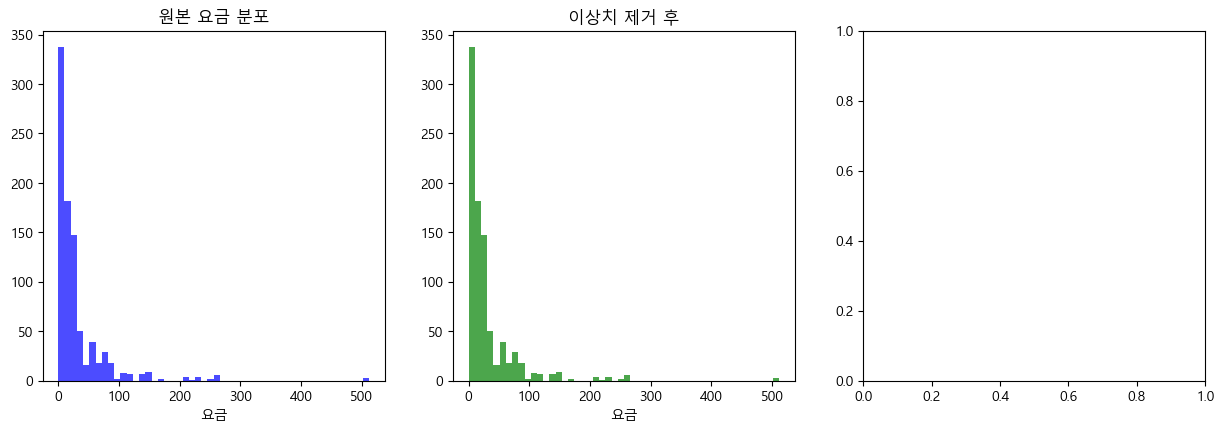

In [ ]:
# 6. 시각화: 처리 방법별 분포 비교
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(titanic['fare'], bins=50, alpha=0.7, color='blue')
plt.title('원본 요금 분포')
plt.xlabel('요금')

plt.subplot(2, 3, 2)
plt.hist(titanic_copy['fare'], bins=50, alpha=0.7, color='green')
plt.title('이상치 제거 후')
plt.xlabel('요금')

plt.subplot(2, 3, 3)
plt.hist(titanic_winsorized['fare'], bins=50, alpha=0.7, color='orange')
plt.title('윈저화 후')
plt.xlabel('요금')

plt.subplot(2, 3, 5)
plt.hist(titanic_replaced['fare'], bins=50, alpha=0.7, color='purple')
plt.title('이상치 대체 후')
plt.xlabel('요금')

plt.subplot(2, 3, 6)
# 박스플롯으로 비교
box_data = [
    titanic['fare'].values,
    titanic_copy['fare'].values,
    titanic_winsorized['fare'].values,
    titanic_replaced['fare'].values
]
plt.boxplot(box_data, labels=['원본', '제거', '윈저화', '대체'])
plt.title('처리 방법별 박스플롯 비교')
plt.ylabel('요금')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 7. 이상치 처리가 분석에 미치는 영향 확인

correlation_comparison = pd.DataFrame({
    '원본': [titanic['fare'].corr(titanic['survived'])],
    '제거': [titanic_copy['fare'].corr(titanic_copy['survived'])],
    '윈저화': [titanic_winsorized['fare'].corr(titanic_winsorized['survived'])],
    '대체': [titanic_replaced['fare'].corr(titanic_replaced['survived'])]
}, index=['요금-생존율 상관계수'])

print("\n이상치 처리가 상관관계에 미치는 영향:")
print(correlation_comparison.round(4))


이상치 처리가 상관관계에 미치는 영향:
                 원본      제거     윈저화      대체
요금-생존율 상관계수  0.2573  0.3517  0.3147  0.3443


# EDA 실습!!!!!!!!!!!!!!!

In [2]:
# 타이타닉 데이터셋 불러오기
# (seaborn 기본 내장된 예제 데이터셋)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# titanic 데이터 DataFrame
titanic = sns.load_dataset('titanic')

### 분석 목표
- 타이타닉 승객의 생존에 영향을 준 주요 요인 파악
- 생존율 개선을 위한 안전 정책 수립 근거 마련
- 위험 그룹 식별 및 우선 구조 대상 결정
- 핵심 질문
    - 어떤 승객 특성이 생존에 가장 큰 영향을 미쳤는가?
    - 사회 경제적 지위가 생존에 영향을 미쳤는가?
    - 나이/성별에 따른 생존 패턴은 어떠한가?

In [3]:
# 1. 기본 정보 파악(데이터 개요)
# 처음 5개 행 보기
print("타이타닉 데이터 미리보기:")
print(titanic.head())

# 데이터셋 정보 확인
print("\n데이터셋 정보:")
print(titanic.info())

# 데이터 요약 통계
print("\n데이터 요약 통계:")
print(titanic.describe())

# 메모링 사용량
print('\n메모리 사용량:')
print(titanic.memory_usage(deep=True).sum() / 1024 , 'mb')

타이타닉 데이터 미리보기:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0 

---생존률 기본 분석---
전체 생존률: 38.4%
생존자: 342, 사망자: 549


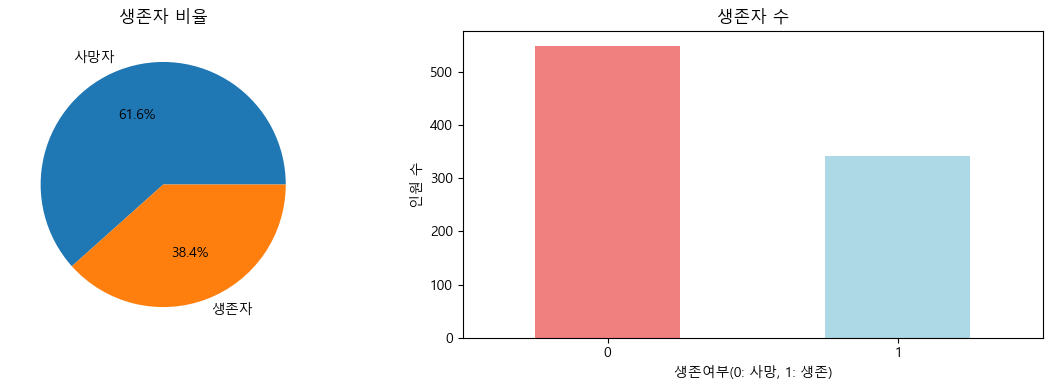

In [4]:
# 2. 생존률 기본 분석
print('---생존률 기본 분석---')
survival_rate = titanic['survived'].mean()
print(f'전체 생존률: {survival_rate:.1%}')

# 생존자/사망자 분포
dead, survivor = titanic['survived'].value_counts()
print(f'생존자: {survivor}, 사망자: {dead}')

# 시각화 (fig 도화지, axes 그려지는 영역)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
a1, a2 = axes
# 사망/생존자 파이그래프
s_counts = titanic['survived'].value_counts()
a1.pie(s_counts, labels=('사망자', '생존자'), autopct='%1.1f%%')
a1.set_title('생존자 비율')

# 생존자 막대그래프
s_counts.plot(kind='bar', ax=a2, color=['lightcoral', 'lightblue'])
a2.set_title('생존자 수')
a2.set_xlabel('생존여부(0: 사망, 1: 생존)')
a2.set_ylabel('인원 수')
a2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [66]:
print("=== EDA 가설 및 우선순위 ===")
print("""
주요 가설들:
1. 여성과 어린이 우선 구조 정책 → 성별과 나이가 생존에 중요한 영향
2. 상류층 우대 구조 → 객실 등급(pclass)이 생존율과 연관
3. 가족 단위 행동 → 동반 가족 수(sibsp, parch)가 생존에 영향
4. 승선 위치 → 항구별(Embarked) 생존율 차이 가능성

분석 우선순위:
1순위: pclass, sex, age 
2순위: sibsp, parch, fare
3순위: embarked (부가 정보)
""")

=== EDA 가설 및 우선순위 ===

주요 가설들:
1. 여성과 어린이 우선 구조 정책 → 성별과 나이가 생존에 중요한 영향
2. 상류층 우대 구조 → 객실 등급(pclass)이 생존율과 연관
3. 가족 단위 행동 → 동반 가족 수(sibsp, parch)가 생존에 영향
4. 승선 위치 → 항구별(Embarked) 생존율 차이 가능성

분석 우선순위:
1순위: pclass, sex, age 
2순위: sibsp, parch, fare
3순위: embarked (부가 정보)



In [ ]:
# 필요하다면, 결측치/이상치를 처리 한다.

=== 객실 등급별 생존율 ===
1 등급: 63.0% - 136 / 216명
2 등급: 47.3% - 87 / 184명
3 등급: 24.2% - 119 / 491명
=== 성별 생존율 ===
female: 74.2% - 233 / 314명
male: 18.9% - 109 / 577명
=== 연령대별 생존율 ===
아동(-12): 58.0% - 40/69명
청소년(13-18): 42.9% - 30/70명
청년(19-35): 38.3% - 137/358명
중장년(36-60): 40.0% - 78/195명
노년(61+): 22.7% - 5/22명


C:\Users\agnes\AppData\Local\Temp\ipykernel_12028\1434218702.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = titanic.groupby('age_group')['survived'].agg(['count', 'sum', 'mean']).dropna()


=== 성별 x 객실등급 교차분석 ===
pclass     1     2     3
sex                     
female  96.8  92.1  50.0
male    36.9  15.7  13.5


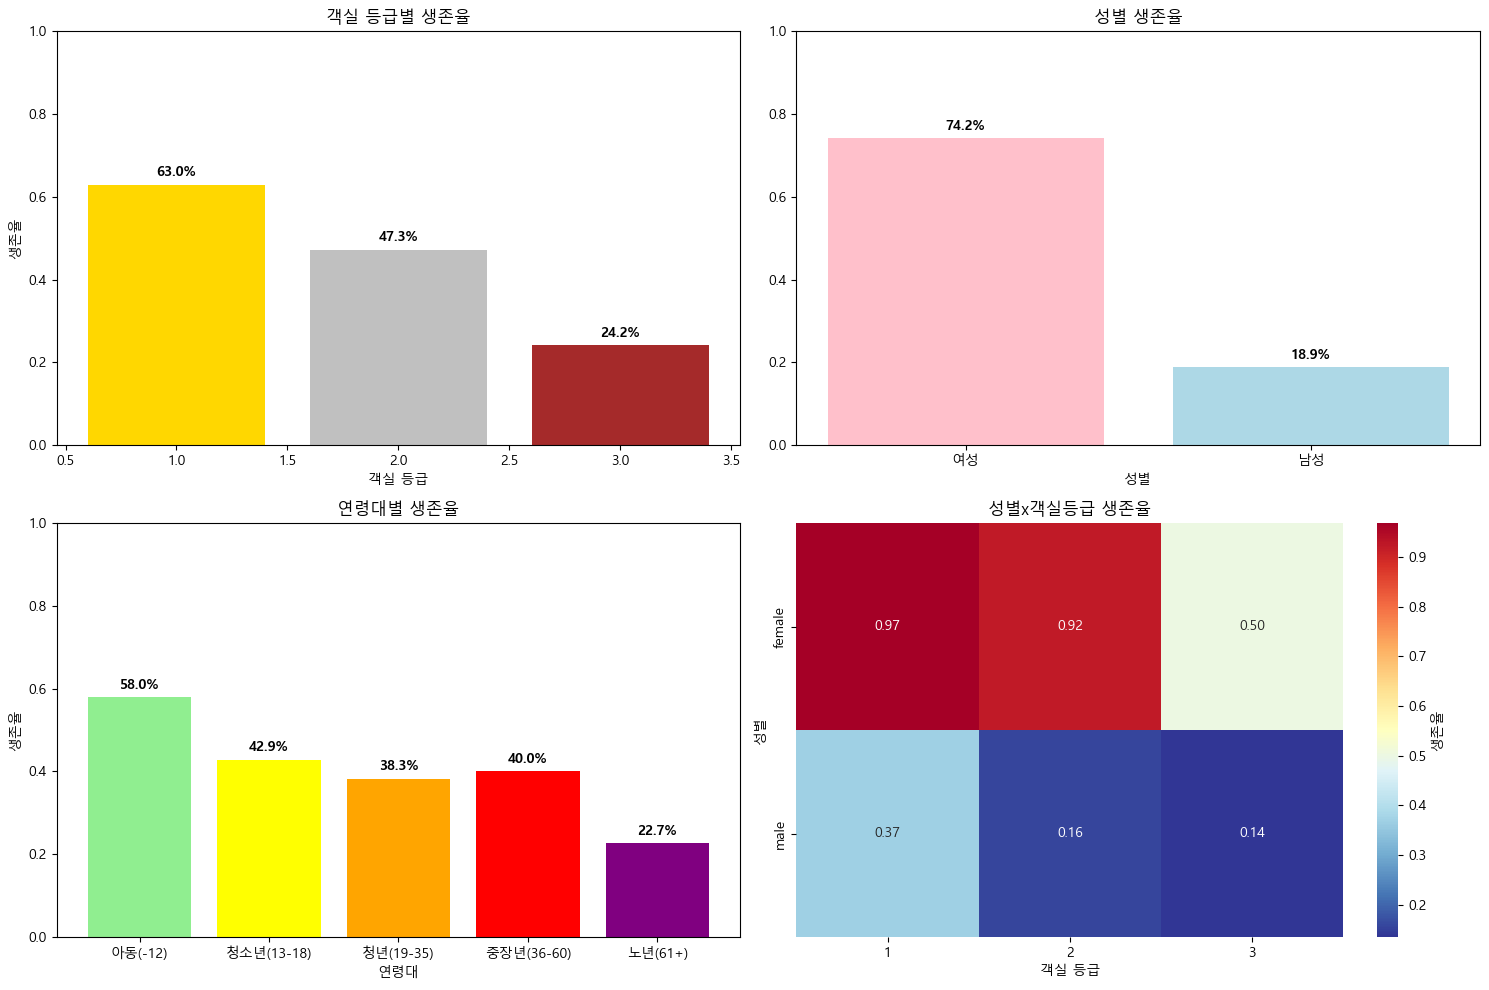

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# 핵심 변수별 생존률 분석
# 1. 객실 등급별 생존률 (총원, 생존, 생존률)
pclass_survival = titanic.groupby('pclass')['survived'].agg(['count', 'sum', 'mean'])

a1.bar(pclass_survival.index, pclass_survival['mean'], color=['gold', 'silver', 'brown'])
a1.set_title('객실 등급별 생존율')
a1.set_xlabel('객실 등급')
a1.set_ylabel('생존율')
a1.set_ylim(0, 1)

# enumerate로 인덱스 붙여서, 표에 퍼센트 표시!!!!!!!!!!!!!!!!!
for idx, value in enumerate(pclass_survival['mean']):
    #       x좌표,   y좌표
    a1.text(idx+1, value + 0.02, f'{value:.1%}', ha='center', fontweight='bold')

print('=== 객실 등급별 생존율 ===')
                            # itter rows 한줄씩 뽑
for idx, row in pclass_survival.iterrows():
    print(f'{idx} 등급: {row['mean']:.1%} - {row['sum'].astype(int)} / {row['count'].astype(int)}명')




# 2. 성별 생존률
sex_survival = titanic.groupby('sex')['survived'].agg(['count', 'sum', 'mean'])
a2.bar(range(len(sex_survival)), sex_survival['mean'], color=['pink', 'lightblue'])
a2.set_title('성별 생존율')
a2.set_xlabel('성별')
# 여기서 라벨링 해준 거
a2.set_xticklabels(['여성', '남성'])
a2.set_xticks(range(len(sex_survival)))
# y값의 limit을 정해준 거
a2.set_ylim(0, 1)
# 표에 퍼센트 값 표시!!!!!!!!!!!!!!!!!
for idx, value in enumerate(sex_survival['mean']):
    a2.text(idx, value + 0.02, f'{value:.1%}', ha='center', fontweight='bold')

print('=== 성별 생존율 ===')
for idx, row in sex_survival.iterrows():
    print(f'{idx}: {row['mean']:.1%} - {row['sum'].astype(int)} / {row['count'].astype(int)}명')




# 3. 나이 생존률(연령대 별)
titanic['age_group'] = pd.cut(
    titanic['age'],
    bins=[0, 12, 18, 35, 60, 100,],  # 초과 ~ 이하
    labels=['아동(-12)', '청소년(13-18)', '청년(19-35)', '중장년(36-60)', '노년(61+)',]
)
age_survival = titanic.groupby('age_group')['survived'].agg(['count', 'sum', 'mean']).dropna()

a3.bar(range(len(age_survival)), age_survival['mean'], 
       color=['lightgreen', 'yellow', 'orange', 'red', 'purple'])
a3.set_title('연령대별 생존율')
a3.set_xlabel('연령대')
a3.set_xticks(range(len(age_survival)))
a3.set_xticklabels(age_survival.index)
a3.set_ylim(0, 1)
a3.set_ylabel('생존율')

for idx, value in enumerate(age_survival['mean']):
    a3.text(idx, value + 0.02, f'{value:.1%}', ha='center', fontweight='bold')

print('=== 연령대별 생존율 ===')
for idx, row in age_survival.iterrows():
    print(f'{idx}: {row['mean']:.1%} - {row['sum'].astype(int)}/{row['count'].astype(int)}명')




# 4. 조합 분석: 성별 x 객실등급 -> GroupBy 말고 Crosstab 으로 해보자
# crosstab( ) - 행과 열의 조합 빈도수를 바로 테이블 형태로 만들어줌.
#                                 성별    x   객실등급 ,           생존             율
survival_ct = pd.crosstab(titanic['sex'], titanic['pclass'], titanic['survived'], aggfunc='mean')
sns.heatmap(survival_ct, annot=True, fmt='.2f', cmap='RdYlBu_r',
            ax=a4, cbar_kws={'label': '생존율'})
a4.set_title('성별x객실등급 생존율')
a4.set_xlabel('객실 등급')
a4.set_ylabel('성별')

print('=== 성별 x 객실등급 교차분석 ===')
print(survival_ct.round(3) * 100)

plt.tight_layout()
plt.show()

In [ ]:
%pip install -q scipy

In [9]:
from scipy.stats import chi2_contingency

# 카이제곱 독립성 검정
sex_survival_ct = pd.crosstab(titanic['sex'], titanic['survived'])
chi2, p_value, dof, expected = chi2_contingency(sex_survival_ct)
'''
chi2 = 카이제곱 통계량
p_value = 유의 확률 (값이 작다 -> 관련이 있다)
- 일반적으로 p_value 가 5%(0.05) 보다 작으면 연관이 있다고 봄

dof = 자유도 (degree of freedom)
exepected = 기대빈도표 (성별-생존이 독립적일때 기대되는 값들)
'''
print(p_value)
if p_value < 0.05:
    print('성별-생존율은 관련 있음')
else:
    print('성별-생존율 관련 없음')

1.1973570627755643e-58
성별-생존율은 관련 있음


In [ ]:
# 5. 분석 결과 보고 (인사이트 정리)
print("""
## 1. 주요 가설

* **가설 1**: 여성과 아동이 우선 구조되었을 것이다.
* **가설 2**: 상류층(1등급)이 구조에서 우대받았을 것이다.

---

## 2. 데이터 요약

### 객실 등급별 생존율

* 1등급: 63.0% (136/216)
* 2등급: 47.3% (87/184)
* 3등급: 24.2% (119/491)

→ 등급이 높을수록 생존율이 높음

### 성별 생존율

* 여성: 74.2% (233/314)
* 남성: 18.9% (109/577)

→ 여성 생존율이 남성보다 약 4배 높음

### 연령대별 생존율

* 아동(-12): 58.0%
* 청소년(13-18): 42.9%
* 청년(19-35): 38.3%
* 중장년(36-60): 40.0%
* 노년(61+): 22.7%

→ 아동 생존율이 가장 높고, 고령층으로 갈수록 낮아짐

### 성별 x 객실 등급 생존율 (%)

| 성별 | 1등급   | 2등급   | 3등급   |
| -- | ----- | ----- | ----- |
| 여성 | 96.8% | 92.1% | 50.0% |
| 남성 | 36.9% | 15.7% | 13.5% |

→ 모든 등급에서 여성 생존율이 높음
→ 특히 1등급 여성은 거의 전원 구조

---

## 3. 가설 검정 결과

✅ **가설 1 채택**: 여성과 아동이 실제로 높은 생존율을 보였으며, 우선 구조된 것으로 해석 가능

✅ **가설 2 채택**: 객실 등급이 높을수록 생존율이 뚜렷하게 높아, 상류층 우선 구조가 있었던 것으로 판단

---

## 4. 결론

* 생존은 **성별, 나이, 객실 등급**에 따라 유의미한 차이를 보임
* **여성, 아동, 상류층**이 구조에 있어 우선순위를 가졌음
* 구조 우선 정책과 사회 계층 간 격차가 생존 결과에 강하게 반영됨
""")

In [ ]:
def get_data_profile(df: pd.DataFrame, target_col=None):
    """종합적인 데이터 프로파일링 함수"""

    print('=' * 50)
    print('종합 데이터 폼질 리포트')
    print('=' * 50)

    # 1. 기본 통계
    print(f'\n1. 기본정보')
    print(f'- 데이터 크기: {df.shape[0]}행 x {df.shape[1]}열')
    print(f'- 메모리 사용량: {df.memory_usage(deep=True).sum()/1024**2:.2f}mb')
    print(f'- 수치형 변수: {len(df.select_dtypes(include=['number']).columns)}개')
    print(f'- 범주형 변수: {len(df.select_dtypes(include=['object']).columns)}개')

    # 2. 결측값 분석
    print(f'\n2. 결측값 분석')
    missing_info = df.isnull().sum()
    m_pct = (missing_info / len(df)) * 100
    if missing_info.sum() == 0:
        print('결측값 없음. 완전')
    else:
        missing_sum = pd.DataFrame({
            '결측수': missing_info,
            '결측율(%)': m_pct,
        }).round(2)
        missing_sum = missing_sum[missing_sum['결측수'] > 0]
        display(missing_sum)

    # 3. 데이터 타입별 분석


get_data_profile(titanic)